# Relax challenge
### Jonas Cuadrado

We have two datasets, 

1. A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years.
2. A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven­day period , identify which factors predict future user
adoption .

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
ue = pd.read_csv('takehome_user_engagement.csv')
ue['time_stamp']=pd.to_datetime(ue['time_stamp'])
ue.head()

In [3]:
# lets find the list of users that are adopted

ue_agg = ue.groupby('user_id').count()
ue_agg=ue_agg[ue_agg['visited']>2]
# potential adopted users: ue_agg.index
# for each of those, I want to see if they have 3 entries within 7 days.

engagedusrs = []
for userid in list(ue_agg.index):
    # take the data for this specific user
    auxdf = ue[ue['user_id']==userid].reset_index()
    # calculate time difference with 2 sessions ago
    auxdf['td']=  auxdf.time_stamp - auxdf.time_stamp.shift(2)
    # find if any time difference is smaller than 7 days
    auxdf['engflag']= auxdf['td']<datetime.timedelta(days=7)
    # if there is any true, it's an adopted user
    if sum(auxdf['engflag'])>0:
        engagedusrs.append(userid)


In [4]:
print('Number of engaged users:', len(engagedusrs))

Number of engaged users: 1602


We have now found all the engaged users, and it's stored in a list. Now, we want to read the dataset that contains the users info and use it to predict the users we hove found.

In [5]:
import chardet
with open('takehome_users.csv', 'rb') as f:
    result = chardet.detect(f.read())

us = pd.read_csv('takehome_users.csv', encoding=result['encoding'])
us = us.set_index('object_id')
us['engaged']=False
us.at[engagedusrs, 'engaged'] = True
us.head(11)

In [6]:
us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
engaged                       12000 non-null bool
dtypes: bool(1), float64(2), int64(3), object(4)
memory usage: 1.2+ MB


Now, let's select the parameters of interest. We note there are only about 1.600 engaged users, but 12.000 total users, so it's a rather strange phenomenon (13%). This can bias the classification model!

Possible interesting parameters:
* creation_time, selecting the time of the day (unlikely, won't be used)
* email domain, maybe gmail users engage more (also unlinkely, but more likely than the previous)
* creation source
* mailing list
* marketing drip
* org id
* invited by another user. That's integrated on the creation source, so will be dropped)

Let's filter them and start thinking!

In [7]:
us['emaildomain']=us['email'].str.split('@').str[1]
df = us[['emaildomain','creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','engaged']]

df.head()

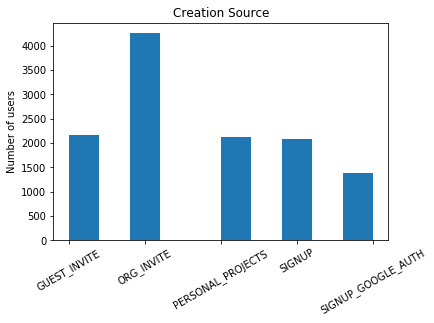

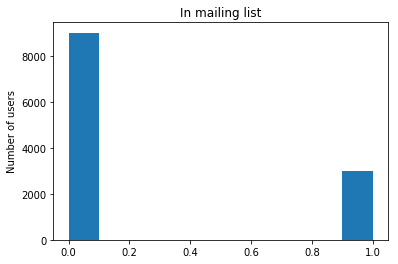

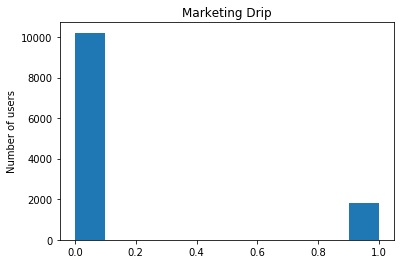

In [8]:
plt.hist(df['creation_source'])
plt.ylabel('Number of users')
plt.xticks(rotation=30)
plt.title('Creation Source')
plt.show()

plt.hist(df['opted_in_to_mailing_list'])
plt.ylabel('Number of users')
#plt.xticks(rotation=30)
plt.title('In mailing list')
plt.show()

plt.hist(df['enabled_for_marketing_drip'])
plt.ylabel('Number of users')
#plt.xticks(rotation=30)
plt.title('Marketing Drip')
plt.show()

In [9]:
print('There are', len(df['emaildomain'].unique()), 'different email domains')
print('There are', len(df['org_id'].unique()), 'different organizations')

There are 1184 different email domains
There are 417 different organizations


To decide on which algorithm to use, we need to consider two things:

* All the data is discrete, there are no continuous variables. This is useful because allows for naive Bayes classifiers.
* The data is heavily unbalanced. We either balance it by resampling or use a penalized SVM or a decision tree.

We observe that the balanced SVM takes too long to run, so I discarded it and stuck with the forest.


In [10]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [11]:
dfencoded = df.copy()

leemail = preprocessing.LabelEncoder()
leemail.fit(df['emaildomain'])
dfencoded['emaildomain']=leemail.transform(df['emaildomain'])

lecs = preprocessing.LabelEncoder()
lecs.fit(df['creation_source'])
dfencoded['creation_source']=lecs.transform(df['creation_source'])

dfencoded.head()


In [12]:
X_train, X_test, y_train, y_test = train_test_split(dfencoded.drop(columns='engaged'),dfencoded['engaged'], test_size=0.2, random_state=42)

For the random forest...

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf2 = RandomForestClassifier(class_weight='balanced')
clf2.fit(X_train, y_train)
 
y_test_pred = clf2.predict(X_test)
 
# Is the model predicting only 1 class?
print(np.unique(y_test_pred))
 

print('RF accuracy:', accuracy_score(y_test, y_test_pred) )
 
# What about AUROC?
prob_y = clf2.predict_proba(X_test)
prob_y = [p[1] for p in prob_y]
print('RF ROC score:', roc_auc_score(y_test, prob_y) )

print('On train data:')
print('TRAIN RF accuracy:', accuracy_score(y_train, clf2.predict(X_train)) )

[False  True]
RF accuracy: 0.78875
RF ROC score: 0.49636900923499244
On train data:
TRAIN RF accuracy: 0.9241666666666667


The linear SVM takes very long compared to the random forest, which already performs quite well. 78% accuracy on the test partiction, but we are clearly overfitting because we achieve 92% on the training set. Still it's a rather good prediction.

In [14]:
# plot confusion matrix as in 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.897 0.103]
 [0.899 0.101]]
Normalized confusion matrix
[[0.951 0.049]
 [0.251 0.749]]


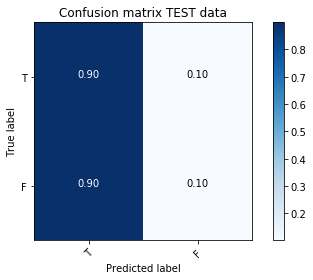

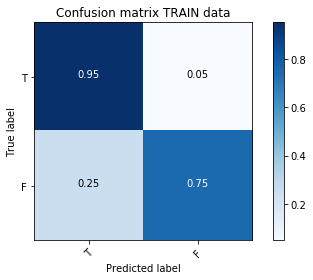

In [15]:
cnf_matrix = confusion_matrix(y_test, y_test_pred)

np.set_printoptions(precision=3)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['T','F'],normalize=True, title='Confusion matrix TEST data')

cnf_matrix = confusion_matrix(y_train, clf2.predict(X_train))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['T','F'],normalize=True, title='Confusion matrix TRAIN data')

We observe poor perfomance on the test dataset predicting the non-adopted users, but a good rate of true positives which is what we actually are aiming for. What factors are the most significant?

In [16]:
for ft,vl in zip(dfencoded.drop(columns='engaged').columns, clf2.feature_importances_):
    print(ft,':', vl)

emaildomain : 0.17379517008268797
creation_source : 0.05226434953567385
opted_in_to_mailing_list : 0.019873542066301132
enabled_for_marketing_drip : 0.018893352939371486
org_id : 0.7351735853759656


We observe the origin id and the email domain to play a major role! This means that users working at certain companies may be more likely to remain as engaged. The email domain as well seems like it.

Should we try to look at the other parameters?

RF accuracy: 0.5395833333333333
RF ROC score: 0.5588434961634257
On train data:
TRAIN RF accuracy: 0.540625
Normalized confusion matrix
[[0.54  0.46 ]
 [0.463 0.537]]
Normalized confusion matrix
[[0.537 0.463]
 [0.434 0.566]]


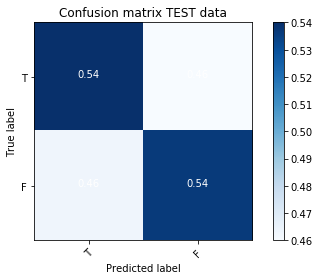

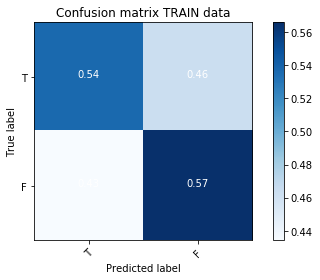

In [17]:
Xtr, Xts, ytr, yts = train_test_split(dfencoded.drop(columns=['engaged','org_id','emaildomain']),dfencoded['engaged'], test_size=0.2, random_state=42)

clf3 = RandomForestClassifier(class_weight='balanced')
clf3.fit(Xtr, ytr)
 
y_ts_pred = clf3.predict(Xts)

print('RF accuracy:', accuracy_score(yts, y_ts_pred) )
 
# What about AUROC?
prob_y = clf3.predict_proba(Xts)
prob_y = [p[1] for p in prob_y]
print('RF ROC score:', roc_auc_score(yts, prob_y) )

print('On train data:')
print('TRAIN RF accuracy:', accuracy_score(ytr, clf3.predict(Xtr)) )

cnf_matrix = confusion_matrix(yts, y_ts_pred)

np.set_printoptions(precision=3)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['T','F'],normalize=True, title='Confusion matrix TEST data')

cnf_matrix = confusion_matrix(ytr, clf3.predict(Xtr))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['T','F'],normalize=True, title='Confusion matrix TRAIN data')

Now, we can improve a little bit the rate of true positives, but the overall performance is worse.